In [1]:
import os
from os.path import dirname as up

# data processing
import rasterio
import pandas as pd
import geopandas as gpd
import numpy as np
from glob import glob

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from rasterio.plot import show
from pandas.plotting import parallel_coordinates

from sklearn.preprocessing import StandardScaler

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

/Users/mirandalv/opt/anaconda3/envs/py37/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.0-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
"""
# 1	Coastal Blue	443 (20)	Yes - with Sentinel-2 band 1
# 2	Blue	490 (50)	Yes - with Sentinel-2 band 2
# 3	Green I	531 (36)	No equivalent with Sentinel-2
# 4	Green	565 (36)	Yes - with Sentinel-2 band 3
# 5	Yellow	610 (20)	No equivalent with Sentinel-2
# 6	Red	665 (31)	Yes - with Sentinel-2 band 4
# 7	Red Edge	705 (15)	Yes - with Sentinel-2 band 5
# 8	NIR	865 (40)	Yes - with Sentinel-2 band 8a
"""

'\n# 1\tCoastal Blue\t443 (20)\tYes - with Sentinel-2 band 1\n# 2\tBlue\t490 (50)\tYes - with Sentinel-2 band 2\n# 3\tGreen I\t531 (36)\tNo equivalent with Sentinel-2\n# 4\tGreen\t565 (36)\tYes - with Sentinel-2 band 3\n# 5\tYellow\t610 (20)\tNo equivalent with Sentinel-2\n# 6\tRed\t665 (31)\tYes - with Sentinel-2 band 4\n# 7\tRed Edge\t705 (15)\tYes - with Sentinel-2 band 5\n# 8\tNIR\t865 (40)\tYes - with Sentinel-2 band 8a\n'

In [4]:
# Loading data
root_dir = up(os.getcwd())
points_data = os.path.join(root_dir, 'data/processing_data/vectors/points_planet_composite.geojson')

gdf = gpd.read_file(points_data)
# gdf.drop(columns=['rand_point'], inplace=True)
gdf.drop(columns=['type_class'], inplace=True)
df = pd.DataFrame(gdf.drop(columns='geometry'))

In [5]:
df.head()

,id,type,layer,path,B1,B2,B3,B4,B5,B6,B7,B8
0,0,alterniflora,RandomPoints_BrownBay_alterniflora,/Users/mirandalv/Documents/projects/github/Mar...,311,278,368,445,534,481,578,589
1,1,alterniflora,RandomPoints_BrownBay_alterniflora,/Users/mirandalv/Documents/projects/github/Mar...,224,266,330,353,438,398,519,859
2,2,alterniflora,RandomPoints_BrownBay_alterniflora,/Users/mirandalv/Documents/projects/github/Mar...,278,327,459,493,569,547,677,838
3,3,alterniflora,RandomPoints_BrownBay_alterniflora,/Users/mirandalv/Documents/projects/github/Mar...,369,458,567,639,739,738,766,1176
4,4,alterniflora,RandomPoints_BrownBay_alterniflora,/Users/mirandalv/Documents/projects/github/Mar...,432,491,648,735,841,701,891,1110


In [6]:
subset_attributes = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8']

alterniflora = round(df[df['type']=='alterniflora'][subset_attributes].describe(),2)
juncus = round(df[df['type']=='juncus'][subset_attributes].describe(),2)

pd.concat([alterniflora, juncus], axis=1, keys=['Alterniflora Statistics', 'Juncus Statistics'])

Alterniflora Statistics                                             \
                           B1      B2      B3       B4       B5       B6   
count                  691.00  691.00  691.00   691.00   691.00   691.00   
mean                   296.71  280.07  349.76   413.33   484.11   447.20   
std                     65.14   77.13   96.63   111.08   118.79   112.25   
min                    163.00  170.00  217.00   276.00   319.00   310.00   
25%                    255.50  229.00  285.50   338.00   405.00   370.00   
50%                    286.00  259.00  323.00   382.00   448.00   411.00   
75%                    322.00  305.00  379.00   447.00   525.00   483.00   
max                    853.00  812.00  957.00  1070.00  1210.00  1139.00   

                        Juncus Statistics                                  \
            B7       B8                B1      B2      B3      B4      B5   
count   691.00   691.00            504.00  504.00  504.00  504.00  504.00   
mean    566.00   880.94            315.29  285.38  343.98  398.94  470.89   
std     124.36   181.99             54.28   48.62   58.02   67.02   78.28   
min     398.00   282.00            186.00  202.00  244.00  281.00  326.00   
25%     482.50   758.00            279.00  250.00  302.00  352.50  414.00   
50%     529.00   836.00            311.00  278.00  332.00  388.50  458.00   
75%     610.00   975.50            343.00  314.00  379.00  440.00  518.00   
max    1358.00  1725.00            588.00  536.00  613.00  698.00  818.00   

                                 
           B6       B7       B8  
count  504.00   504.00   504.00  
mean   442.25   577.83  1096.10  
std     81.98    95.51   168.22  
min    317.00   390.00   282.00  
25%    378.75   508.75   995.00  
50%    424.00   564.50  1092.00  
75%    489.00   631.25  1190.25  
max    825.00  1034.00  1726.00

## Univariate Analysis

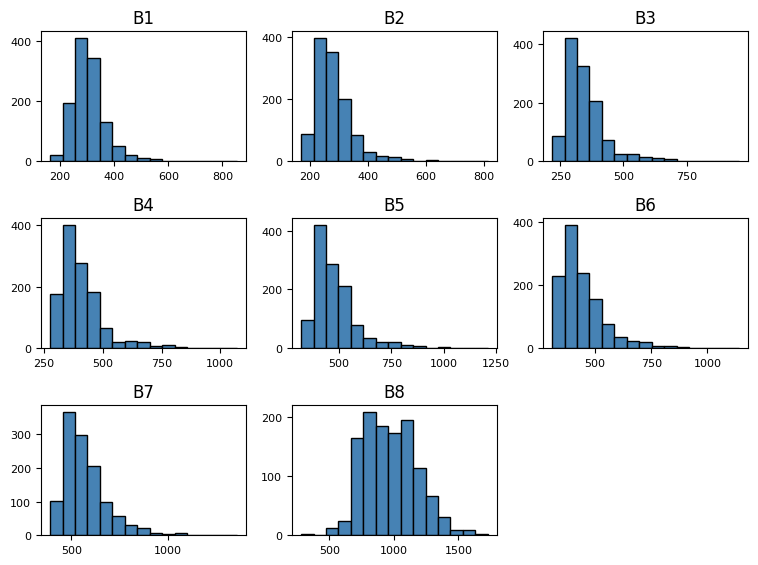

In [7]:
# all dataset
df.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))   

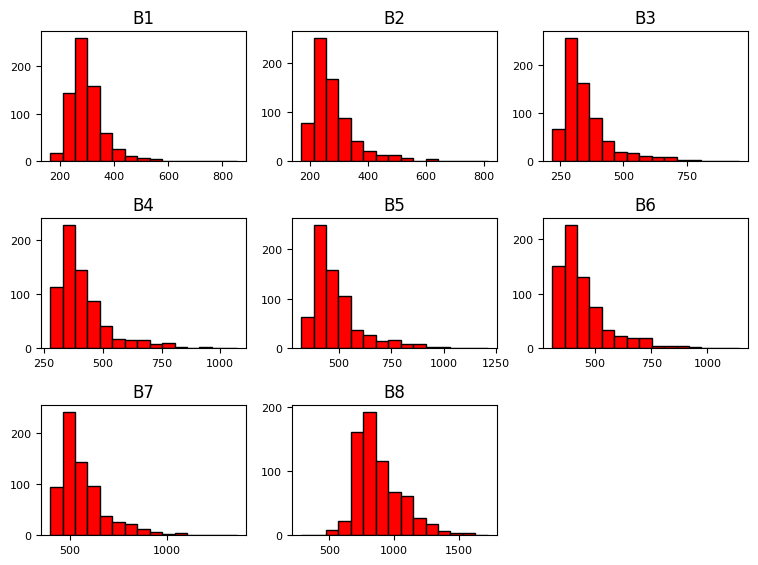

In [8]:
df[df['type']=='alterniflora'].hist(bins=15, color='red', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2)) 

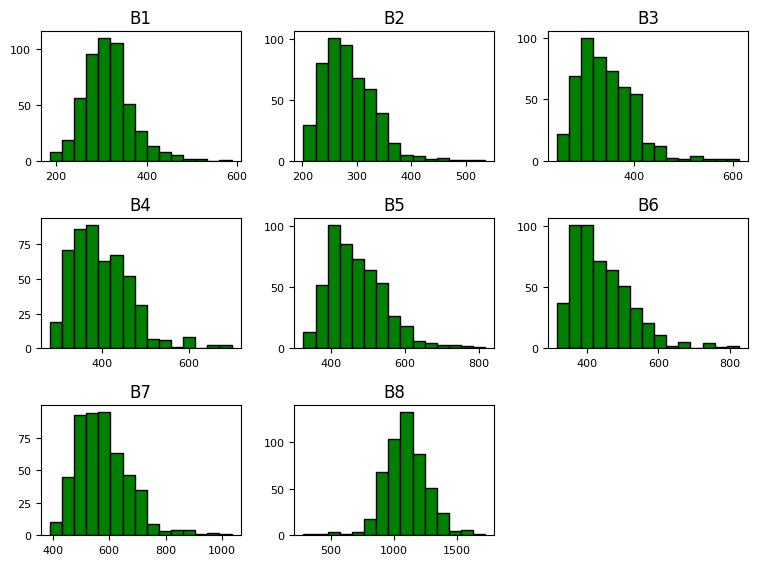

In [9]:
df[df['type']=='juncus'].hist(bins=15, color='green', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2)) 

## Multivariate Analysis

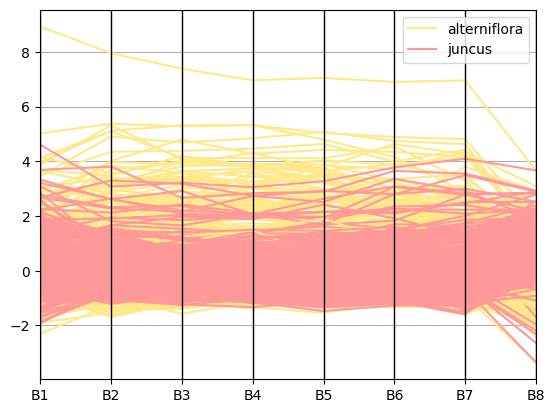

In [10]:
# data scale
# Scaling attribute values to avoid few outiers
cols = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8']
subset_df = df[cols]

ss = StandardScaler()

scaled_df = ss.fit_transform(subset_df)
scaled_df = pd.DataFrame(scaled_df, columns=cols)
final_df = pd.concat([scaled_df, df['type']], axis=1)
final_df.head()

# plot parallel coordinates

"""
Points are represented as connected line segments. 
Each vertical line represents one data attribute. 
One complete set of connected line segments across all the attributes represents one data point. 
Hence points that tend to cluster will appear closer together. 
"""
pc = parallel_coordinates(final_df, 'type', color=('#FFE888', '#FF9999'))

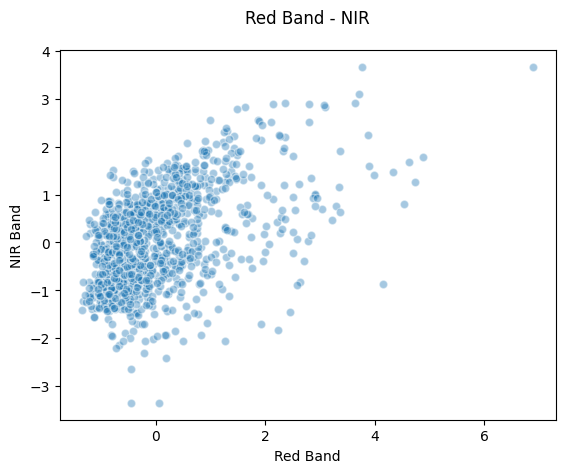

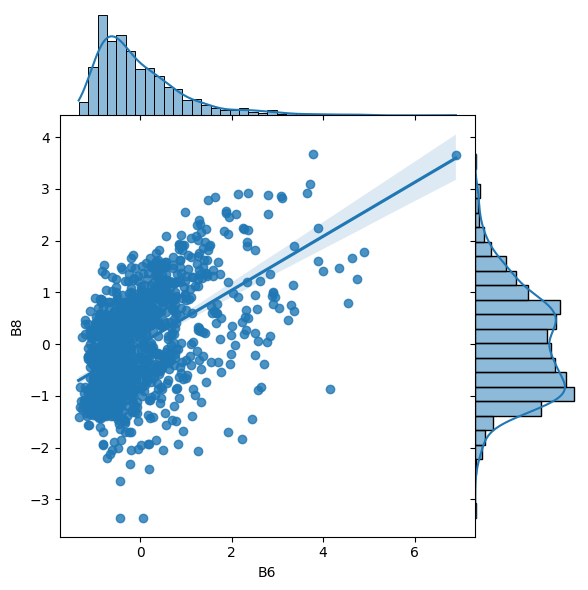

In [11]:
# Scatter Plot
plt.scatter(final_df['B6'], final_df['B8'],
            alpha=0.4, edgecolors='w')

plt.xlabel('Red Band')
plt.ylabel('NIR Band')
plt.title('Red Band - NIR',y=1.05)

# Joint Plot
jp = sns.jointplot(x='B6', y='B8', data=final_df,
                   kind='reg', space=0, ratio=4)


### Pair wise vis

/Users/mirandalv/opt/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


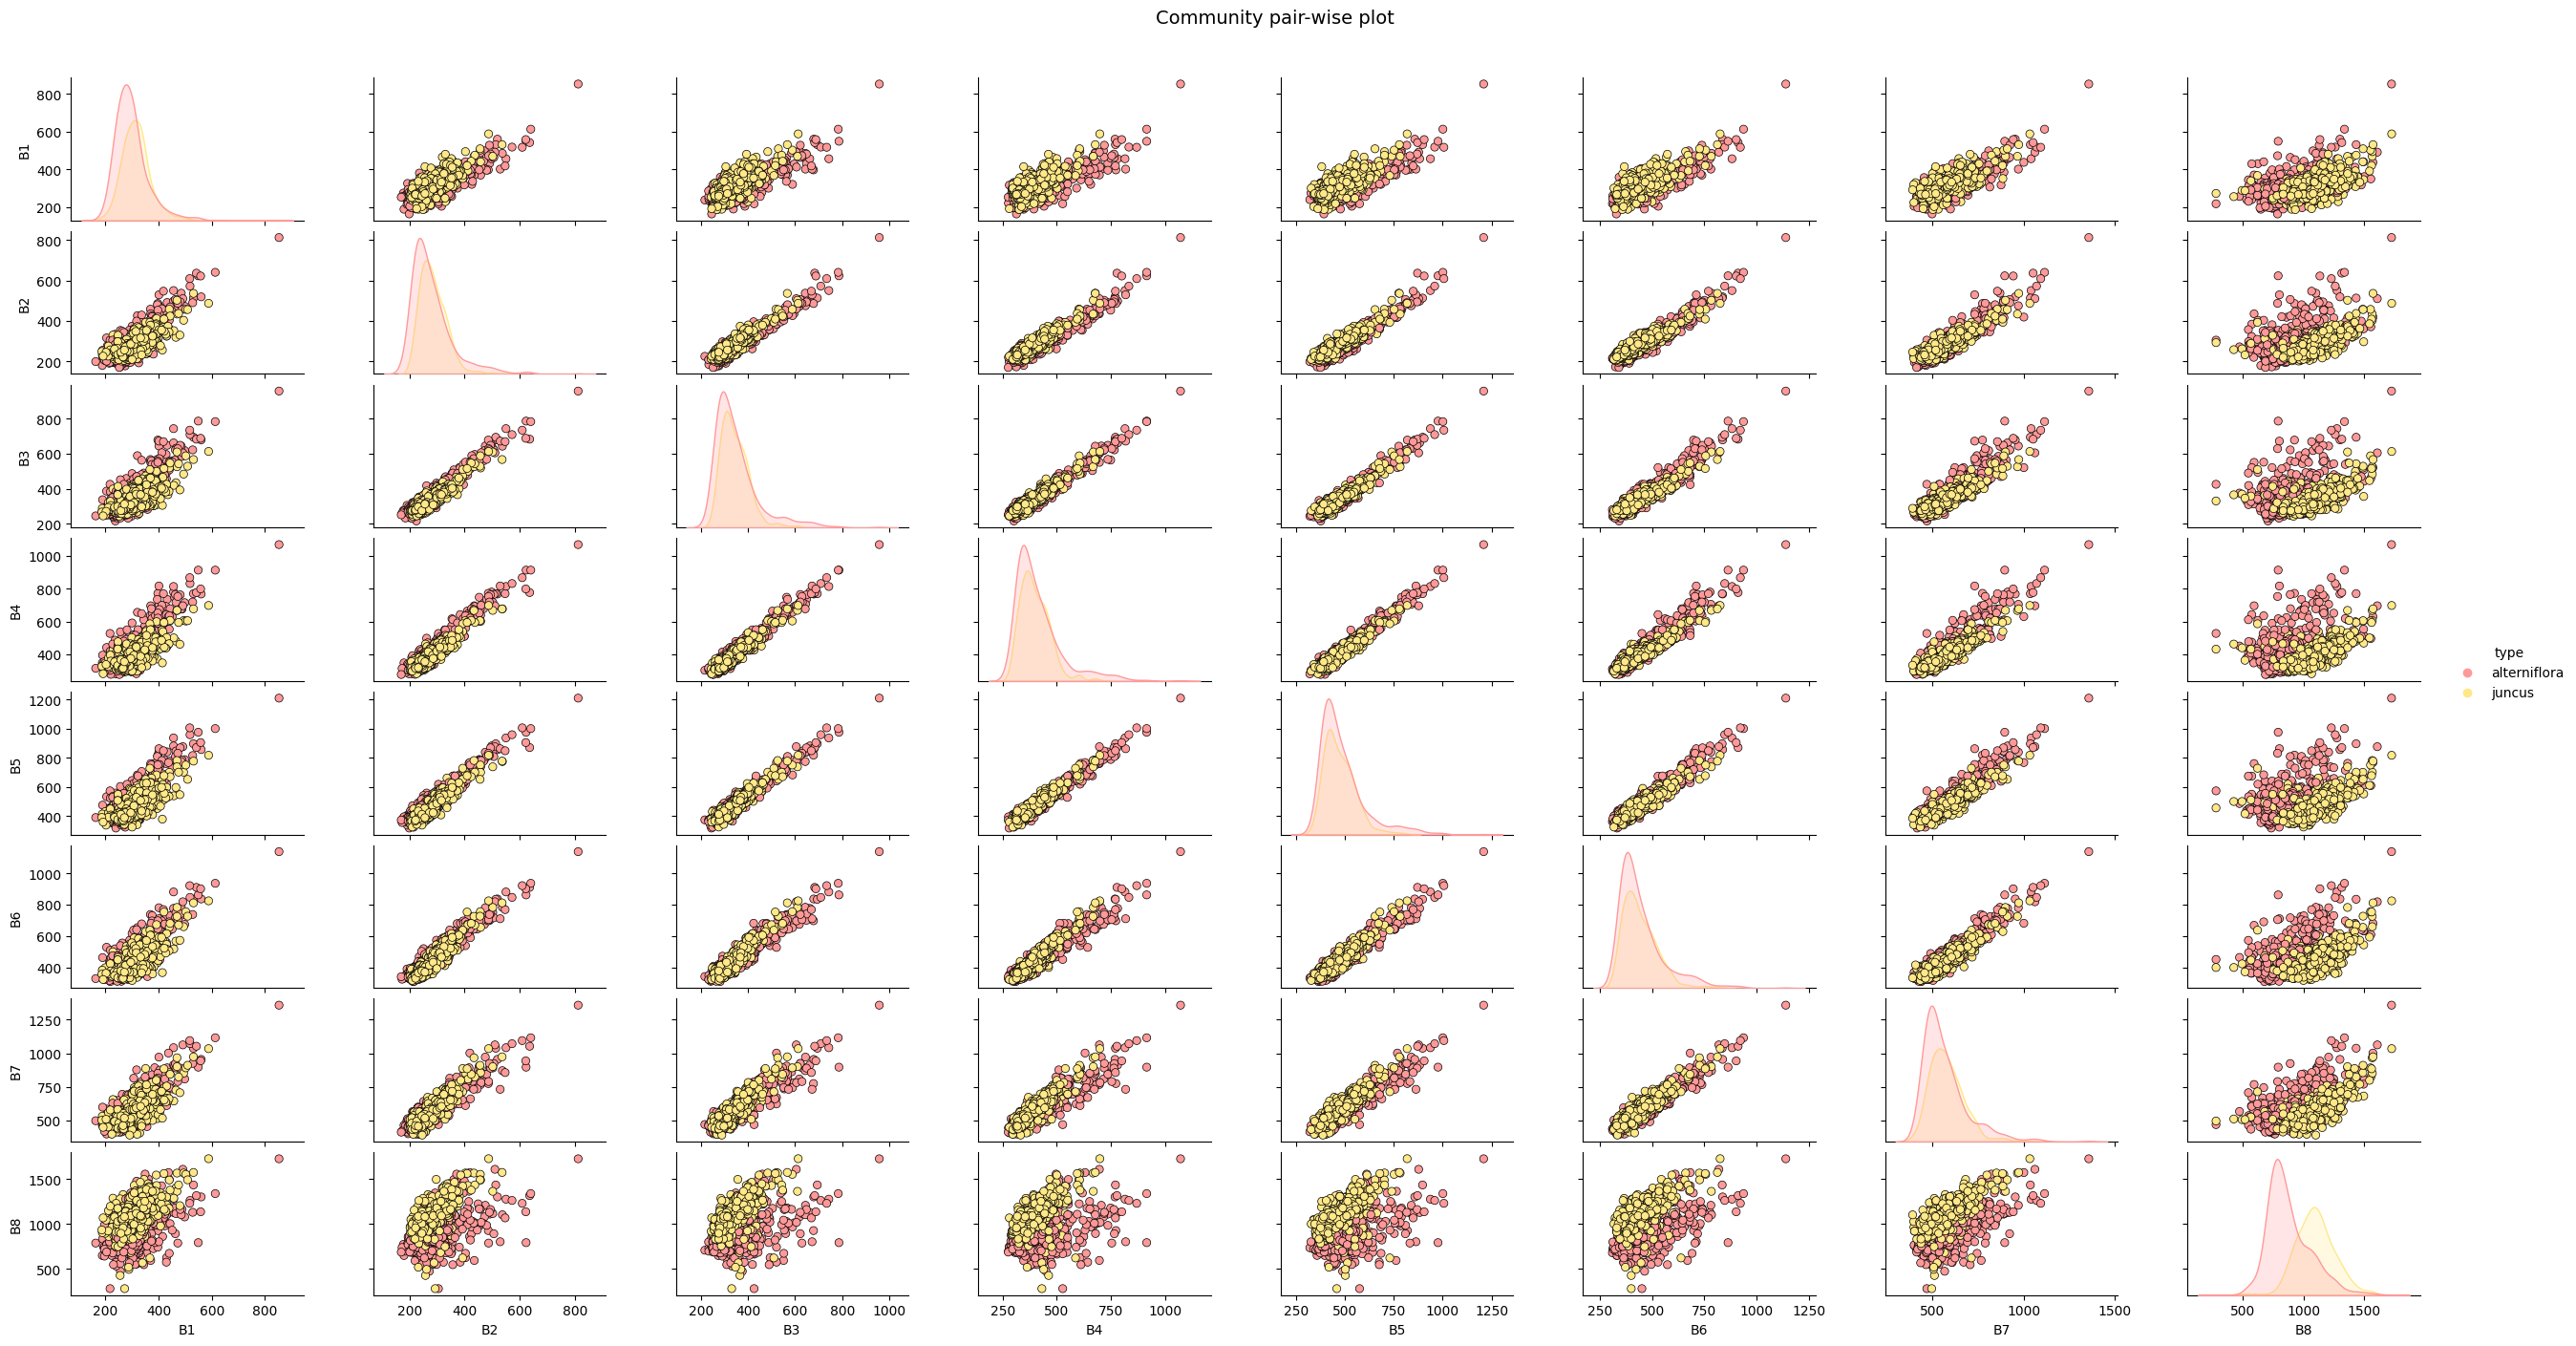

In [12]:
# Scatter Plot with Hue for visualizing data in 3-D
cols = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'type']
pp = sns.pairplot(df[cols], hue='type', size=1.8, aspect=1.8, 
                  palette={"alterniflora": "#FF9999", "juncus": "#FFE888"},
                  plot_kws=dict(edgecolor="black", linewidth=0.5))
fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Community pair-wise plot', fontsize=14)

### Aggregate into mean value of each band and check on the distribution

<AxesSubplot:>

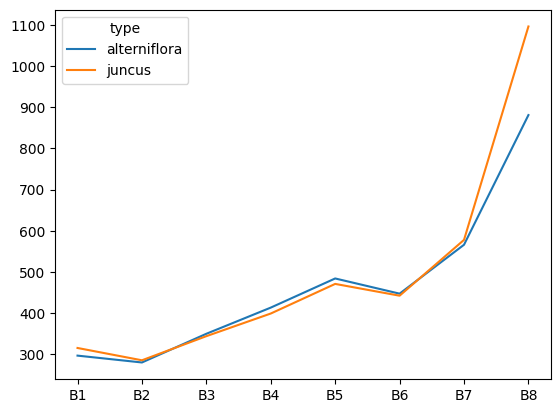

In [13]:
# data visualization of each band
grouped_df = df.groupby('type').mean()
grouped_df = grouped_df.T
index = pd.Index(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8'])
grouped_df = grouped_df.set_index(index)
grouped_df.plot()

Text(0, 0.5, 'NIR Band')

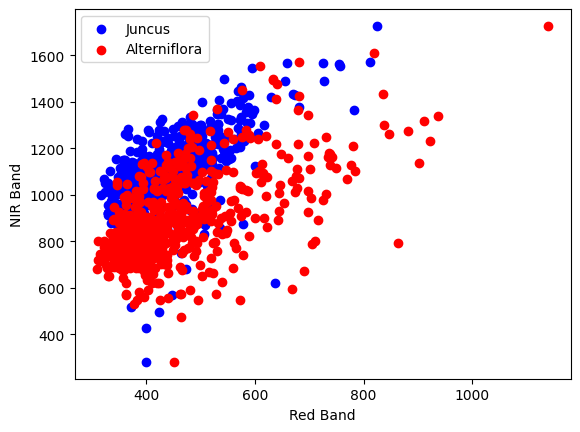

In [14]:
# Making the plot of Red and NIR band for each class
y = df['type']          # Split off classifications
X = df[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8']] # Split off features

plt.scatter(X[y=='juncus']['B6'], X[y=='juncus']['B8'], label='Juncus', c='blue')
plt.scatter(X[y=='alterniflora']['B6'], X[y=='alterniflora']['B8'], label='Alterniflora', c='red')

# Prettify the graph
plt.legend()
plt.xlabel('Red Band')
plt.ylabel('NIR Band')

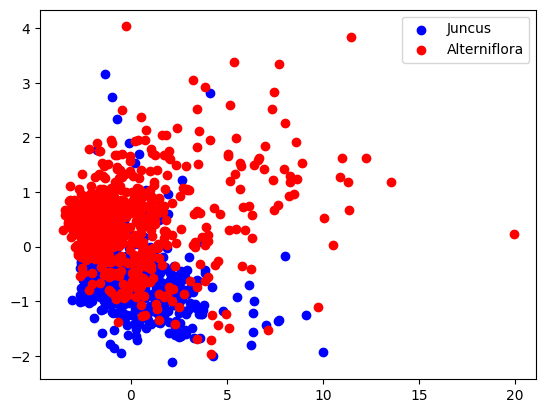

In [15]:
# PCA
from sklearn.decomposition import PCA as sklearnPCA

# y = df['type']          # Split off classifications
# X = df[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8']] # Split off features
# X_norm = (X - X.min())/(X.max() - X.min()) # need to refine

y = final_df['type']
X_norm = final_df[['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8']]

pca = sklearnPCA(n_components=2) #2-dimensional PCA
pca_transformed = pd.DataFrame(pca.fit_transform(X_norm))

plt.scatter(pca_transformed[y=='juncus'][0], pca_transformed[y=='juncus'][1], label='Juncus', c='blue')
plt.scatter(pca_transformed[y=='alterniflora'][0], pca_transformed[y=='alterniflora'][1], label='Alterniflora', c='red')

plt.legend()
plt.show()

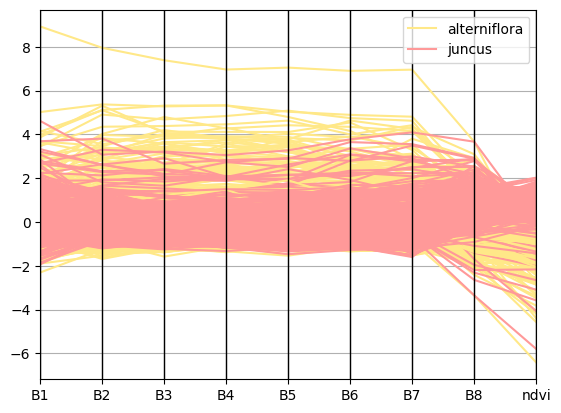

In [16]:
# get NDVI
df['ndvi'] = gdf.apply(lambda x: (x['B8'] - x['B6']) / (x['B8'] + x['B6']), axis=1)

# data scale
# Scaling attribute values to avoid few outiers
cols = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'ndvi']
subset_df = df[cols]

ss = StandardScaler()

scaled_df = ss.fit_transform(subset_df)
scaled_df = pd.DataFrame(scaled_df, columns=cols)
final_df = pd.concat([scaled_df, df['type']], axis=1)
final_df.head()

# plot parallel coordinates with NDVI
pc = parallel_coordinates(final_df, 'type', color=('#FFE888', '#FF9999'))

Text(0, 0.5, 'NDVI')

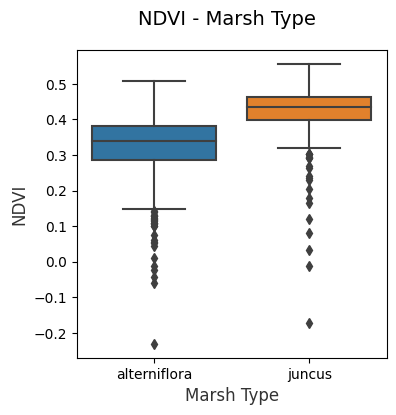

In [17]:
# NDVI distribution of each category

# Box Plots
f, (ax) = plt.subplots(1, 1, figsize=(4, 4))
f.suptitle('NDVI - Marsh Type', fontsize=14)

sns.boxplot(x="type", y="ndvi", data=df,  ax=ax)
ax.set_xlabel("Marsh Type",size = 12,alpha=0.8)
ax.set_ylabel("NDVI",size = 12,alpha=0.8)

Text(0, 0.5, 'NDVI')

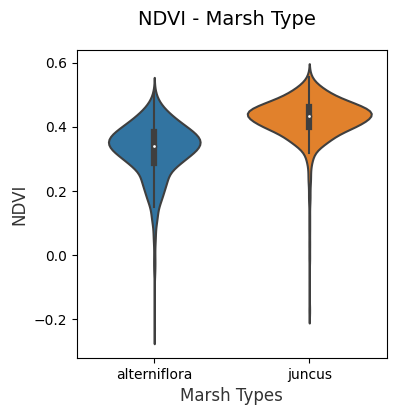

In [18]:
# Violin Plots of NDVI

f, (ax) = plt.subplots(1, 1, figsize=(4, 4))
f.suptitle('NDVI - Marsh Type', fontsize=14)

sns.violinplot(x="type", y="ndvi", data=df,  ax=ax)
ax.set_xlabel("Marsh Types",size = 12,alpha=0.8)
ax.set_ylabel("NDVI",size = 12,alpha=0.8)

In [19]:
df[df['ndvi']<0]

,id,type,layer,path,B1,B2,B3,B4,B5,B6,B7,B8,ndvi
128,128,alterniflora,RandomPoints_BrownBay_alterniflora,/Users/mirandalv/Documents/projects/github/Mar...,370,435,551,696,761,669,767,595,-0.058544
297,297,alterniflora,RandomPoints_BrownBay_alterniflora,/Users/mirandalv/Documents/projects/github/Mar...,217,305,426,527,574,451,468,282,-0.230559
341,341,alterniflora,RandomPoints_BrownBay_alterniflora,/Users/mirandalv/Documents/projects/github/Mar...,549,623,786,914,976,863,896,793,-0.042271
436,436,alterniflora,RandomPoints_BrownBay_alterniflora,/Users/mirandalv/Documents/projects/github/Mar...,344,357,490,611,675,573,706,548,-0.022302
544,544,alterniflora,RandomPoints_BrownBay_alterniflora,/Users/mirandalv/Documents/projects/github/Mar...,440,403,552,635,684,691,744,674,-0.012454
624,12,juncus,RandomPoints_BrownBay_Juncus,/Users/mirandalv/Documents/projects/github/Mar...,272,293,331,431,457,400,495,282,-0.173021
692,80,juncus,RandomPoints_BrownBay_Juncus,/Users/mirandalv/Documents/projects/github/Mar...,367,393,510,586,729,638,713,623,-0.011895
